# FDIC Failed Bank List: Exploratory Data Analysis

#### Dataset: The FDIC's open source failed bank list of banks that have failed since October 1, 2000
#### Link: https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/
#### Business/Understanding goal: Learn more about the distrobution of failed banks

# 1. Import Libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.express as px
import geocoder as gc

# 2. Load The Dataset

In [13]:
# Because there are non-UTF characters in the file, we need to specify the encoding
df = pd.read_csv('data/banklist.csv', encoding='latin-1')

# 3. Understand The Data

### Read in basic information about the dataset

In [14]:
print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Bank Name               568 non-null    object
 1   City                    568 non-null    object
 2   State                   568 non-null    object
 3   Cert                    568 non-null    int64 
 4   Acquiring Institution   568 non-null    object
 5   Closing Date            568 non-null    object
 6   Fund                    568 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 31.2+ KB
None
Bank Name                 0
City                      0
State                     0
Cert                      0
Acquiring Institution     0
Closing Date              0
Fund                      0
dtype: int64


### Check for duplicates

In [15]:
# Check for duplicates
dupes = df.duplicated()
print(dupes.sum())

0


### Understand the unique values for each column

In [16]:
# Understand the unique values in each column
for col in df.columns:
    print(df[col].unique())

['Citizens Bank' 'Heartland Tri-State Bank' 'First Republic Bank'
 'Signature Bank' 'Silicon Valley Bank' 'Almena State Bank'
 'First City Bank of Florida' 'The First State Bank' 'Ericson State Bank'
 'City National Bank of New Jersey' 'Resolute Bank'
 'Louisa Community Bank' 'The Enloe State Bank'
 'Washington Federal Bank for Savings'
 'The Farmers and Merchants State Bank of Argonia' 'Fayette County Bank'
 'Guaranty Bank, (d/b/a BestBank in Georgia & Michigan)' 'First NBC Bank'
 'Proficio Bank' 'Seaway Bank and Trust Company' 'Harvest Community Bank'
 'Allied Bank' 'The Woodbury Banking Company' 'First CornerStone Bank'
 'Trust Company Bank' 'North Milwaukee State Bank'
 'Hometown National Bank' 'The Bank of Georgia' 'Premier Bank'
 'Edgebrook Bank' 'Doral Bank' 'Capitol City Bank & Trust Company'
 'Highland Community Bank' 'First National Bank of Crestview'
 'Northern Star Bank' 'Frontier Bank, FSB D/B/A El Paseo Bank'
 'The National Republic Bank of Chicago' 'NBRS Financial'
 'Gre

#### For Acquiring Intitution, some names had N.A. in them. This does not indicate a null value, but a national association. Additionally, many had "No Acquirer". These values will be kept as they are stil valid failed banks and should be analyzed.

# 4. Clean the data

### Remove the /xa0 character from the column names

In [17]:
# Remove the \xa0 character from the column names
name_dict = {
   "Bank Name\xa0" : "Name",
    "City\xa0" : "City",
    "State\xa0" : "State",
    "Cert\xa0" : "Cert",
    "Acquiring Institution\xa0" : "Acquiring Institution",
    "Closing Date\xa0" : "Closing Date",
    "Fund" : "Fund"
}

df = df.rename(columns=name_dict)

### Drop unnecessary columns

In [18]:
# Drop cert and fund columns
df = df.drop(columns=["Cert", "Fund"])

These columns are dropped as they are ID numbers relating to the specific bank and cannot be analyzed

### Add a column for the longitude and latitude of the locations

In [19]:
# Decode a town name to a lattitude and longitude
def decode_town(town):
    result = gc.osm(town)
    return result.latlng
    
# Add a new column to the dataframe with the formatted town name
df["Location"] = df["City"] + ", " + df["State"]
df.drop(columns=["City"], inplace=True)


City is dropped, as location is meant to replace city as a more specific version of the name

In [20]:
# Add a new column to the dataframe with the lattitude and longitude
mode = "read" # Set to "decode" to decode the town names, or "read" to read the coordinates from the file
if mode == "decode":
    # This takes 5 minutes to run and needs to be run only once
    df["Coordinates"] = df["Location"].apply(decode_town)
    
    # Get the lattitude and longitude from the coordinates
    df["Lattitude"] = df["Coordinates"].map(lambda x: x[0])
    df["Longitude"] = df["Coordinates"].map(lambda x: x[1])
    
    # Drop the coordinates column
    df = df.drop(columns=["Coordinates"])
    
    # Save the coordinates to a csv file for later use
    coords_df = df[["Lattitude", "Longitude"]]
    coords_df.to_csv('data/coords.csv')
    
elif mode == "read":
    # Read the coordinates from the file
    coords_df = pd.read_csv('data/coords.csv')
    df["Lattitude"] = coords_df["Lattitude"]
    df["Longitude"] = coords_df["Longitude"]




In [21]:
# Ensure no null values are present
print(df["Lattitude"].isna().sum())
print(df["Longitude"].isna().sum())

print(df.loc[df["Lattitude"] == 0])
print(df.loc[df["Longitude"] == 0])

df.head(10)

0
0
Empty DataFrame
Columns: [Name, State, Acquiring Institution, Closing Date, Location, Lattitude, Longitude]
Index: []
Empty DataFrame
Columns: [Name, State, Acquiring Institution, Closing Date, Location, Lattitude, Longitude]
Index: []


,Name,State,Acquiring Institution,Closing Date,Location,Lattitude,Longitude
0,Citizens Bank,IA,Iowa Trust & Savings Bank,3-Nov-23,"Sac City, IA",42.422115,-94.988584
1,Heartland Tri-State Bank,KS,"Dream First Bank, N.A.",28-Jul-23,"Elkhart, KS",37.002764,-101.897330
2,First Republic Bank,CA,"JPMorgan Chase Bank, N.A.",1-May-23,"San Francisco, CA",37.779026,-122.419906
3,Signature Bank,NY,"Flagstar Bank, N.A.",12-Mar-23,"New York, NY",40.712728,-74.006015
4,Silicon Valley Bank,CA,FirstCitizens Bank & Trust Company,10-Mar-23,"Santa Clara, CA",37.233325,-121.684635
5,Almena State Bank,KS,Equity Bank,23-Oct-20,"Almena, KS",39.892229,-99.707058
6,First City Bank of Florida,FL,"United Fidelity Bank, fsb",16-Oct-20,"Fort Walton Beach, FL",30.405755,-86.618842
7,The First State Bank,WV,"MVB Bank, Inc.",3-Apr-20,"Barboursville, WV",38.409530,-82.294592
8,Ericson State Bank,NE,Farmers and Merchants Bank,14-Feb-20,"Ericson, NE",41.779924,-98.678582
9,City National Bank of New Jersey,NJ,Industrial Bank,1-Nov-19,"Newark, NJ",40.735657,-74.172367


### Use datetime to format dates

In [22]:
# Use the pandas to_datetime function to convert the "Closing Date" column to a datetime object
df["Closing Date"] = pd.to_datetime(df["Closing Date"])
df.head(5)

C:\Users\ltm14\AppData\Local\Temp\ipykernel_19312\2873121882.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Closing Date"] = pd.to_datetime(df["Closing Date"])


,Name,State,Acquiring Institution,Closing Date,Location,Lattitude,Longitude
0,Citizens Bank,IA,Iowa Trust & Savings Bank,2023-11-03,"Sac City, IA",42.422115,-94.988584
1,Heartland Tri-State Bank,KS,"Dream First Bank, N.A.",2023-07-28,"Elkhart, KS",37.002764,-101.897330
2,First Republic Bank,CA,"JPMorgan Chase Bank, N.A.",2023-05-01,"San Francisco, CA",37.779026,-122.419906
3,Signature Bank,NY,"Flagstar Bank, N.A.",2023-03-12,"New York, NY",40.712728,-74.006015
4,Silicon Valley Bank,CA,FirstCitizens Bank & Trust Company,2023-03-10,"Santa Clara, CA",37.233325,-121.684635


In [23]:
# Check for null date values
print(df["Closing Date"].isna().sum())

0


### Add a region column

In [24]:
# Create a dictionary to map states to regions
# Generated with CoPilot
regions = {
    "Northeast" : ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"],
    "Midwest" : ["IL", "IN", "MI", "OH", "WI", "IA", "KS", "MN", "MO", "NE", "ND", "SD"],
    "Southeast" : ["DE", "FL", "GA", "MD", "NC", "SC", "VA", "DC", "WV"],
    "South" : ["AL", "KY", "MS", "TN", "AR", "LA", "OK", "TX"],
    "West" : ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY", "AK", "CA", "HI", "OR", "WA"]
}

# Create a function to map the state to the region
def format_region(abbr):
    for key in regions:
        if abbr in regions[key]:
            return key
    return "Other"

# Map the state to the region
df["Region"] = df["State"].map(format_region)
df.head(5)

,Name,State,Acquiring Institution,Closing Date,Location,Lattitude,Longitude,Region
0,Citizens Bank,IA,Iowa Trust & Savings Bank,2023-11-03,"Sac City, IA",42.422115,-94.988584,Midwest
1,Heartland Tri-State Bank,KS,"Dream First Bank, N.A.",2023-07-28,"Elkhart, KS",37.002764,-101.897330,Midwest
2,First Republic Bank,CA,"JPMorgan Chase Bank, N.A.",2023-05-01,"San Francisco, CA",37.779026,-122.419906,West
3,Signature Bank,NY,"Flagstar Bank, N.A.",2023-03-12,"New York, NY",40.712728,-74.006015,Northeast
4,Silicon Valley Bank,CA,FirstCitizens Bank & Trust Company,2023-03-10,"Santa Clara, CA",37.233325,-121.684635,West


In [25]:
# Check for "Other" values
df.loc[df["Region"] == "Other"]

# These values are valid and should be kept as they are Puerto Rican and not null values

# Rename "Other" to "Puerto Rico"
# Help recieved from tbone's thread on stackoverflow
df["Region"] = df["Region"].replace("Other", "Puerto Rico")

####  No further data cleaning has to be done. There are no null values or duplicated rows in this data set so no rows or columns need to be dropped. 

# 5. Exploratory Data Analysis

### Univariate:

* How are failed banks distributed region-wise?
* How are failed banks distrubuted region-wise?
* How are failed banks distributed country-wise?
* What is the distribution of failed banks over time?
* In what month do most banks fail?
* Which institutions have accquired the most banks?

<Axes: xlabel='State', ylabel='Count'>

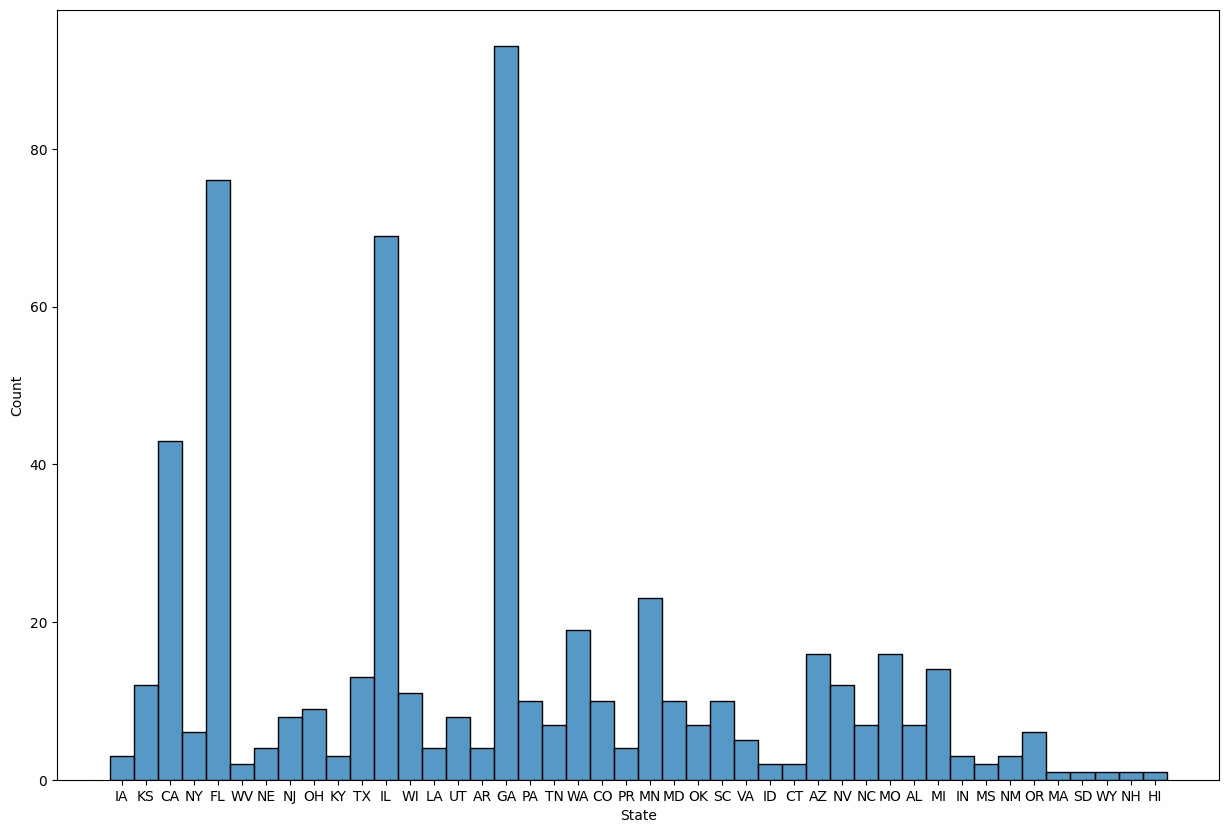

In [26]:
# Create a histplot of the failed banks by state and only show the top 10 states
plt.figure(figsize=(15, 10))
sns.histplot(df["State"])

<Axes: xlabel='Region', ylabel='Count'>

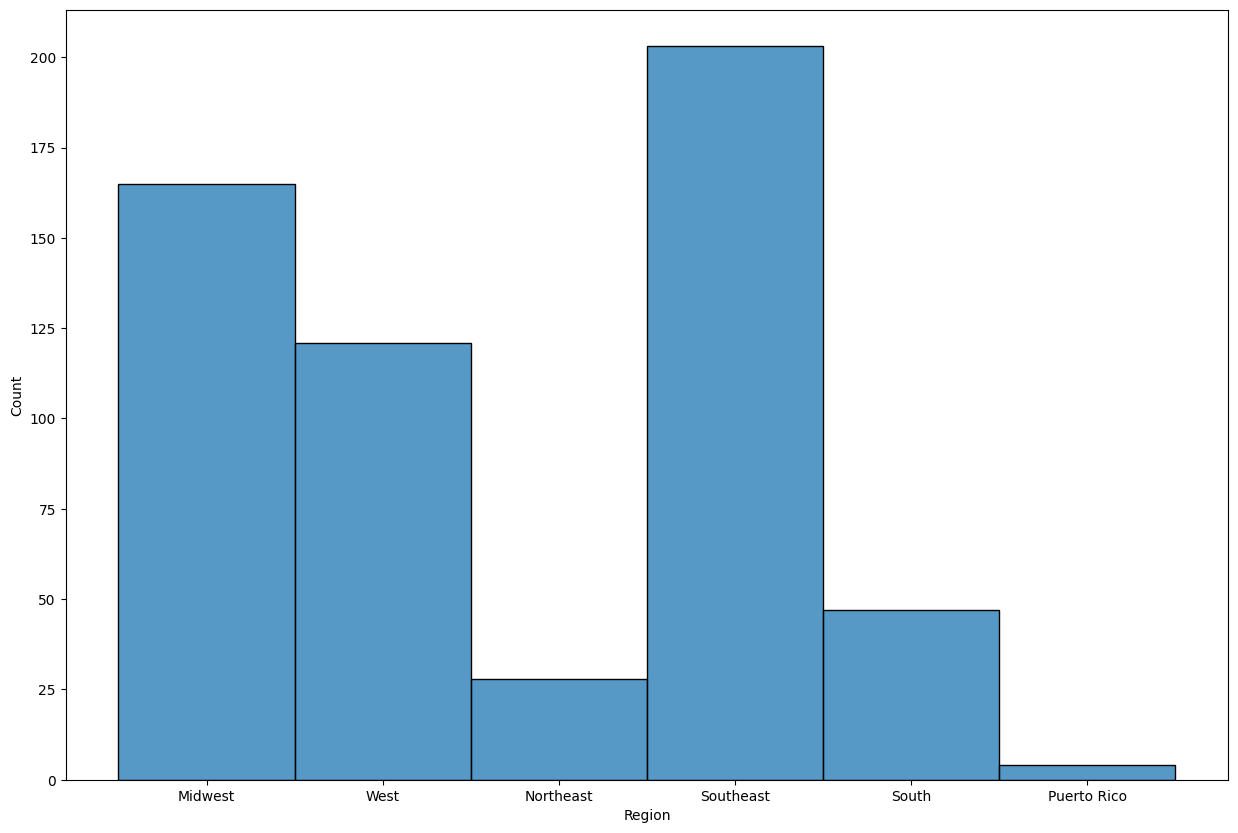

In [27]:
# Create a histplot of the failed banks by region
plt.figure(figsize=(15, 10))
sns.histplot(df["Region"])

In [28]:
# Use the plotly express library to create a scatter_geo map of the failed banks
map = px.scatter_geo(df, lat="Lattitude", lon="Longitude", hover_name="Name", scope="usa", title="Failed Banks in the USA")

map.show()

([<matplotlib.axis.XTick at 0x213caac0710>,
 [Text(2000, 0, '2000'),
  Text(2001, 0, '2001'),
  Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019')])

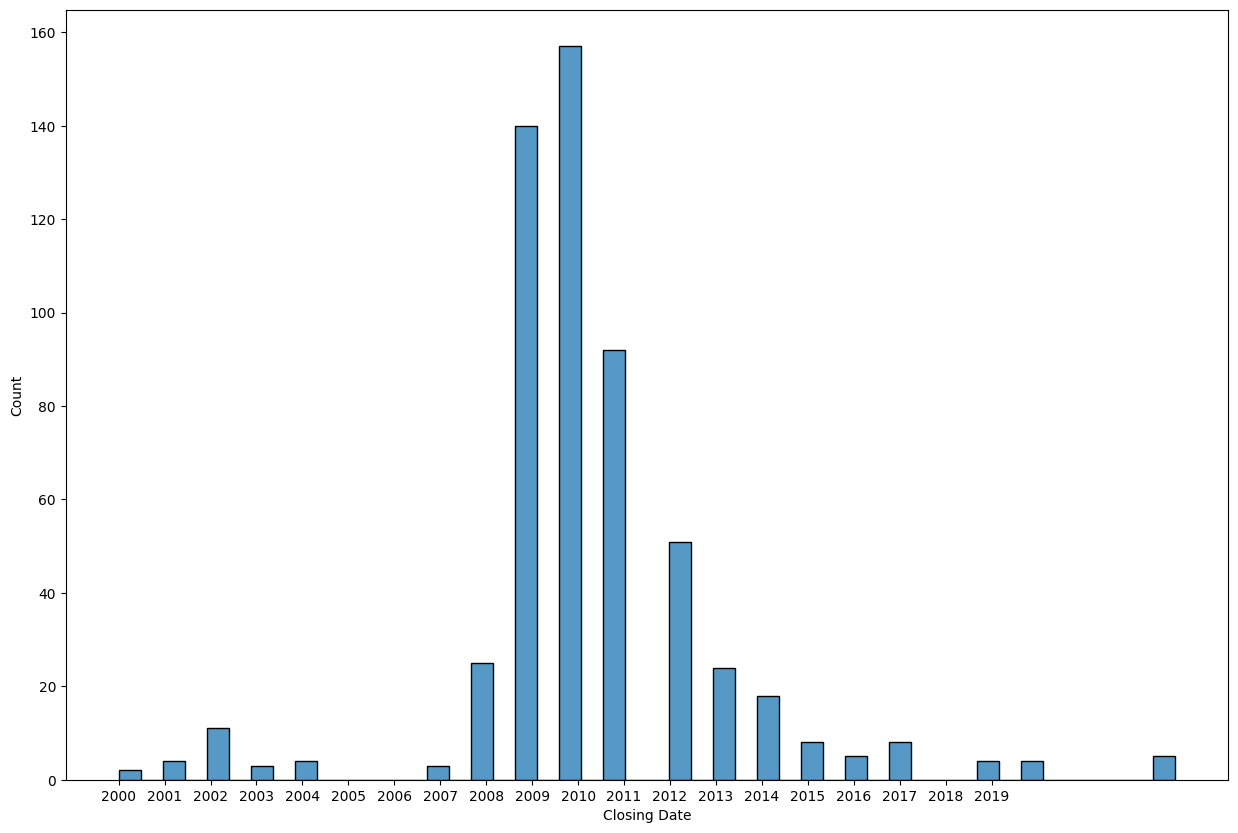

In [29]:
# Create a line plot of the failed banks by year
plt.figure(figsize=(15, 10))
sns.histplot(df["Closing Date"].dt.year)

# Ensure each year has its own tick
plt.xticks(range(2000, 2020, 1))

([<matplotlib.axis.XTick at 0x213caba6b90>,
 [Text(1, 0, 'Jan'),
  Text(2, 0, 'Feb'),
  Text(3, 0, 'Mar'),
  Text(4, 0, 'Apr'),
  Text(5, 0, 'May'),
  Text(6, 0, 'Jun'),
  Text(7, 0, 'Jul'),
  Text(8, 0, 'Aug'),
  Text(9, 0, 'Sep'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Nov'),
  Text(12, 0, 'Dec')])

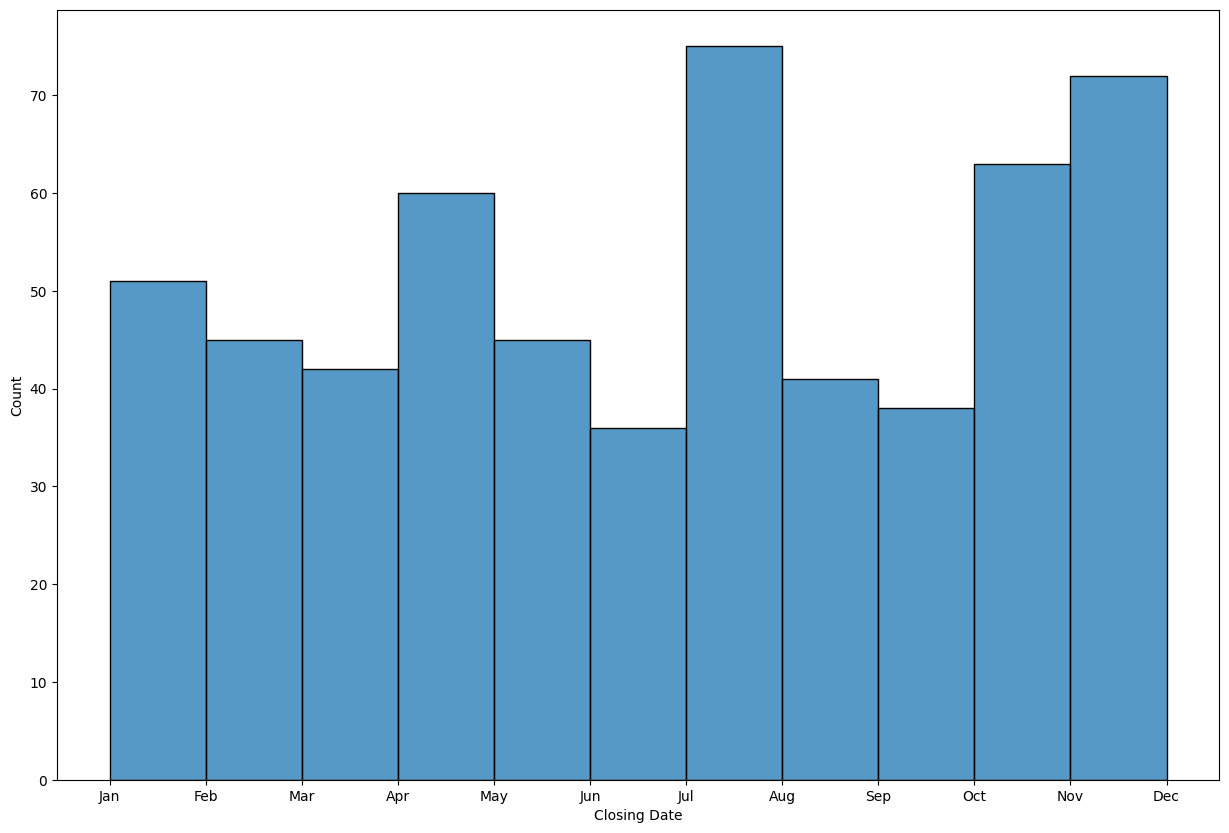

In [30]:
# Create a histplot of the failed banks by month
plt.figure(figsize=(15, 10))
sns.histplot(df["Closing Date"].dt.month)

# Set the tick labels to the month names
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'First-Citizens Bank & Trust Company'),
  Text(1, 0, 'Community & Southern Bank'),
  Text(2, 0, 'No Acquirer'),
  Text(3, 0, 'Centennial Bank'),
  Text(4, 0, 'Ameris Bank'),
  Text(5, 0, 'Stearns Bank, N.A.'),
  Text(6, 0, 'CenterState Bank of Florida, N.A.'),
  Text(7, 0, 'State Bank and Trust Company'),
  Text(8, 0, 'Bank of the Ozarks'),
  Text(9, 0, 'U.S. Bank N.A.')])

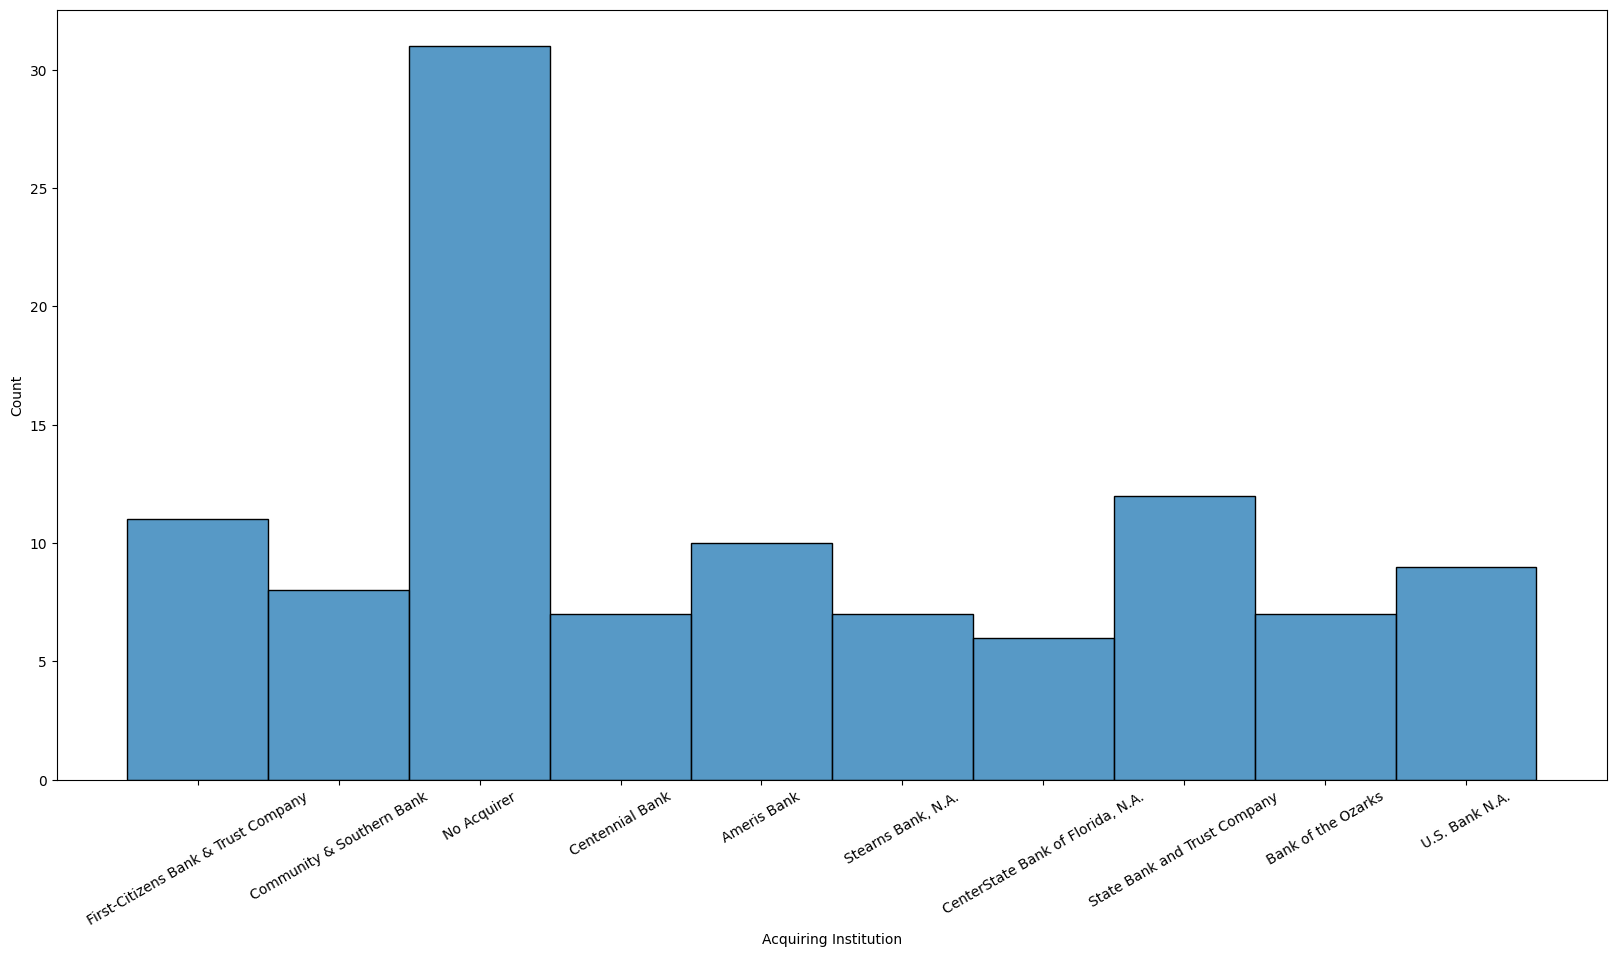

In [31]:
# Get only the values from the top 10 acquiring institutions
acquiring = df["Acquiring Institution"].value_counts().head(10).index
df_acquiring = df.loc[df["Acquiring Institution"].isin(acquiring)]

# Create a histplot of the failed banks by acquisition institution
plt.figure(figsize=(20, 10))
sns.histplot(df_acquiring["Acquiring Institution"])
plt.xticks(rotation=30)

# 6. Statistical Analysis

### 1. What is the most popular acquiring institution in each region?


In [32]:
# Get the most popular acquiring institution in each region
counts = df.groupby("Region")["Acquiring Institution"].value_counts()
counts.groupby(level=0).head(2)

Region       Acquiring Institution       
Midwest      No Acquirer                      7
             MB Financial Bank, N.A.          6
Northeast    No Acquirer                      3
             Capital Bank, N.A.               2
Puerto Rico  Banco Popular de Puerto Rico     2
             Oriental Bank and Trust          1
South        U.S. Bank N.A.                   3
             AloStar Bank of Commerce         1
Southeast    State Bank and Trust Company    12
             Ameris Bank                     10
West         No Acquirer                     10
             Columbia State Bank              5
Name: count, dtype: int64

From this information, we can conclude that large acquiring institutions operate regionwide. Each region has its own distinct largest acquiring institution, with no overlap between the largest institutions in each region


### 2. What state has the most failed banks in each region?


In [33]:
# Find the state with the most failed banks in each region
state_counts = df.groupby("Region")["State"].value_counts()
state_counts.groupby(level=0).head(1)

Region       State
Midwest      IL       69
Northeast    PA       10
Puerto Rico  PR        4
South        TX       13
Southeast    GA       93
West         CA       43
Name: count, dtype: int64

From this information, we can see the worst states to keep money in a bank. The states with the most failed banks tend to be ones with large cities and economies, which is what we would expect. Larger state economies can be more variable than smaller economies and give way to a bank failure


### 3. What states have the most recently failed banks?

In [34]:
# Sort the dataframe by the "Closing Date" column
df = df.sort_values(by="Closing Date", ascending=False)
df.head(10)  

,Name,State,Acquiring Institution,Closing Date,Location,Lattitude,Longitude,Region
0,Citizens Bank,IA,Iowa Trust & Savings Bank,2023-11-03,"Sac City, IA",42.422115,-94.988584,Midwest
1,Heartland Tri-State Bank,KS,"Dream First Bank, N.A.",2023-07-28,"Elkhart, KS",37.002764,-101.897330,Midwest
2,First Republic Bank,CA,"JPMorgan Chase Bank, N.A.",2023-05-01,"San Francisco, CA",37.779026,-122.419906,West
3,Signature Bank,NY,"Flagstar Bank, N.A.",2023-03-12,"New York, NY",40.712728,-74.006015,Northeast
4,Silicon Valley Bank,CA,FirstCitizens Bank & Trust Company,2023-03-10,"Santa Clara, CA",37.233325,-121.684635,West
5,Almena State Bank,KS,Equity Bank,2020-10-23,"Almena, KS",39.892229,-99.707058,Midwest
6,First City Bank of Florida,FL,"United Fidelity Bank, fsb",2020-10-16,"Fort Walton Beach, FL",30.405755,-86.618842,Southeast
7,The First State Bank,WV,"MVB Bank, Inc.",2020-04-03,"Barboursville, WV",38.409530,-82.294592,Southeast
8,Ericson State Bank,NE,Farmers and Merchants Bank,2020-02-14,"Ericson, NE",41.779924,-98.678582,Midwest
9,City National Bank of New Jersey,NJ,Industrial Bank,2019-11-01,"Newark, NJ",40.735657,-74.172367,Northeast


As we can see, the most recently failed bank is Citizens Bank in Iowa, which failed only 3 month ago. We can also note Silicon Valley Bank, whose forclosure was a major news story in may of last year. Of the last 10 banks that failed, California and Kansas have each possessed two of them, showing an upwards trend of failed banks comparatively to other states not in the top 10

# 7. Presentation

### What questions did this analysis lead to?

* How can we quantify a bank failure in terms of severity?
* Do states with lots of failed banks (PA, IL, GA) have problematic laws?
* How does US bank failure compare to bank failure outside of the US?

### What further steps would I take?

Further use:
* Expand the dataset to before 2000
* Include information of how much money the bank lost and how many clients it had, how severe was the failure?
* Specify the type/cause of failure, how did the bank fail?


AI Model Training:
* With the information we currently have, it would not be worth training a model on this data. Without knowing how or why these banks failed, an AI cannot learn to predict future failure.

